In [1]:
"""
Anastasia Pupo
April 2025
CS 5330
Final Project
"""

'\nAnastasia Pupo\nApril 2025\nCS 5330\nFinal Project\n'

In [2]:
"""
Program to perform transfer learning utilizing pre-trained ResNet50 CNN.

Code Resource: https://github.com/nachi-hebbar/Transfer-Learning-ResNet-Keras/blob/main/ResNet_50.ipynb
"""

'\nProgram to perform transfer learning utilizing pre-trained ResNet50 CNN.\n\nCode Resource: https://github.com/nachi-hebbar/Transfer-Learning-ResNet-Keras/blob/main/ResNet_50.ipynb\n'

In [3]:
# get modules
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense

In [4]:
# Define constants of image size, batch size, channels, and epochs
IMAGE_SIZE = 256
BATCH_SIZE = 32  # 32 is a standard batch size
CHANNELS = 3
EPOCHS = 11 # trial and error to determine, 11 was decided to peform best having had epochs at 50 before

In [5]:
'''
Download the images utilizing tensorflow dataset. All images are loaded into a tensor.
'''
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "10Knots",
    shuffle=True, #randomly shuffle images
    image_size = (IMAGE_SIZE, IMAGE_SIZE), #specify image size
    batch_size = BATCH_SIZE
)

Found 1440 files belonging to 10 classes.


2025-04-23 20:47:30.512063: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-23 20:47:30.512263: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-23 20:47:30.512278: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-23 20:47:30.512467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 20:47:30.512482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
class_names = dataset.class_names # get class names

In [6]:
'''
Method splits the 10Knot dataset into training, validation, and test dataset.
Split percentages hard-coded into method signature. 80% for train_split, 0.1% for validation_split and 0.1% for test_split
Return: train_dataset, validation_dataset, test_dataset
'''
def get_dataset_partitions_tf(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12) #same seed gives same result so used for predictability
    
    train_size = int(train_split * dataset_size) # convert to int so dont get float
    validation_size = int(validation_split * dataset_size)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    return train_dataset, validation_dataset, test_dataset

In [7]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset) # Calls partition_dataset

In [8]:
# Optimizes for training performance in an attempt to speed up training.
# Cache for image read from disk, so that for the next iteration if need the same image will already be in memory & improve performance.
# If gpu is occupied, prefetch will have cpu load next set of batch from disk to further improve performance.
# Tensorflow will determine how many batches to load in prefetch

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
"""
Build the convolutional neural network and train using train_dataset.
Measure accuracy using test dataset.
"""

'\nBuild the convolutional neural network and train using train_dataset.\nMeasure accuracy using test dataset.\n'

In [10]:
'''
Transfer Learning with ResNet50 Architecture
'''
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,  #get ResNet50 model
                   input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))

In [11]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
'''
Define optimizer, loss function, and metric
'''
# Compile using optimizers, adam is a famous optimizer. 
# Define loss function
# Accuracy is the metric used to track the training process and gradient descent
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
epochs=EPOCHS
history = resnet_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/11


2025-04-23 20:47:33.904272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 931ms/step - accuracy: 0.3451 - loss: 3.2820 - val_accuracy: 0.7891 - val_loss: 0.6411
Epoch 2/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 843ms/step - accuracy: 0.8626 - loss: 0.4560 - val_accuracy: 0.8359 - val_loss: 0.4993
Epoch 3/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 756ms/step - accuracy: 0.9074 - loss: 0.2824 - val_accuracy: 0.9219 - val_loss: 0.2381
Epoch 4/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 777ms/step - accuracy: 0.9334 - loss: 0.2093 - val_accuracy: 0.9531 - val_loss: 0.1549
Epoch 5/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 778ms/step - accuracy: 0.9821 - loss: 0.1014 - val_accuracy: 0.9688 - val_loss: 0.1202
Epoch 6/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 799ms/step - accuracy: 0.9743 - loss: 0.1051 - val_accuracy: 0.9922 - val_loss: 0.0942
Epoch 7/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 755ms/step - accuracy: 0.9935 - loss: 0.0627 - val_accuracy: 0.9688 - val_loss: 0.0954
Epoch 8/11
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 737ms/step - accuracy: 0.9922 - loss: 0.0530 - val_accuracy: 0.976

In [14]:
"""
Test the model with test_dataset to determine accuracy
"""

'\nTest the model with test_dataset to determine accuracy\n'

In [15]:
scores = resnet_model.evaluate(test_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 668ms/step - accuracy: 0.9949 - loss: 0.0286


In [16]:
#scores parameter is a python list where first parameter is loss and second is accuracy
scores

[0.029658574610948563, 0.9937499761581421]

In [17]:
"""
Visualize results
"""

'\nVisualize results\n'

In [18]:
# Get accuracies and losses
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

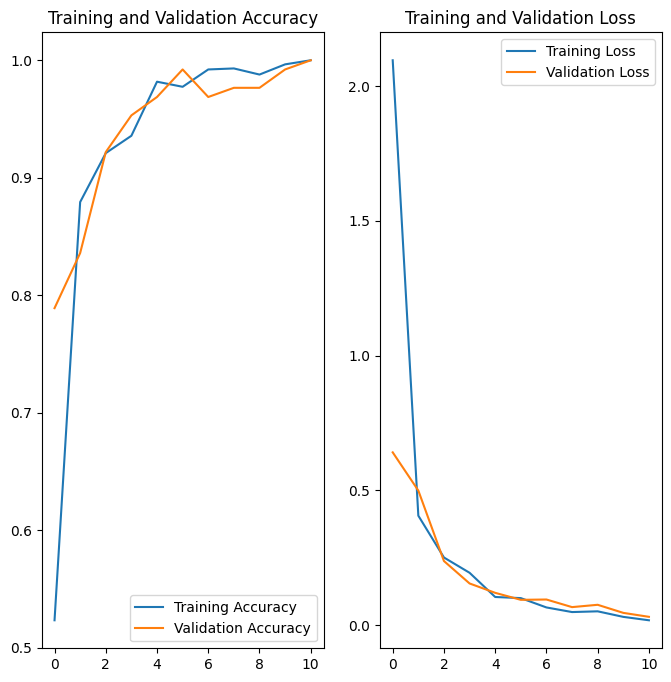

In [19]:
# plot training versus validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy, label = 'Training Accuracy')
plt.plot(range(EPOCHS),validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot training loss versus validation loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label = 'Training Loss')
plt.plot(range(EPOCHS),validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
'''
Method utilizes model to predict class of an image.
Returns the predicted class and percent confidence in prediction.
'''
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)
    predictions = model.predict(image_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


2025-04-23 20:58:51.627460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


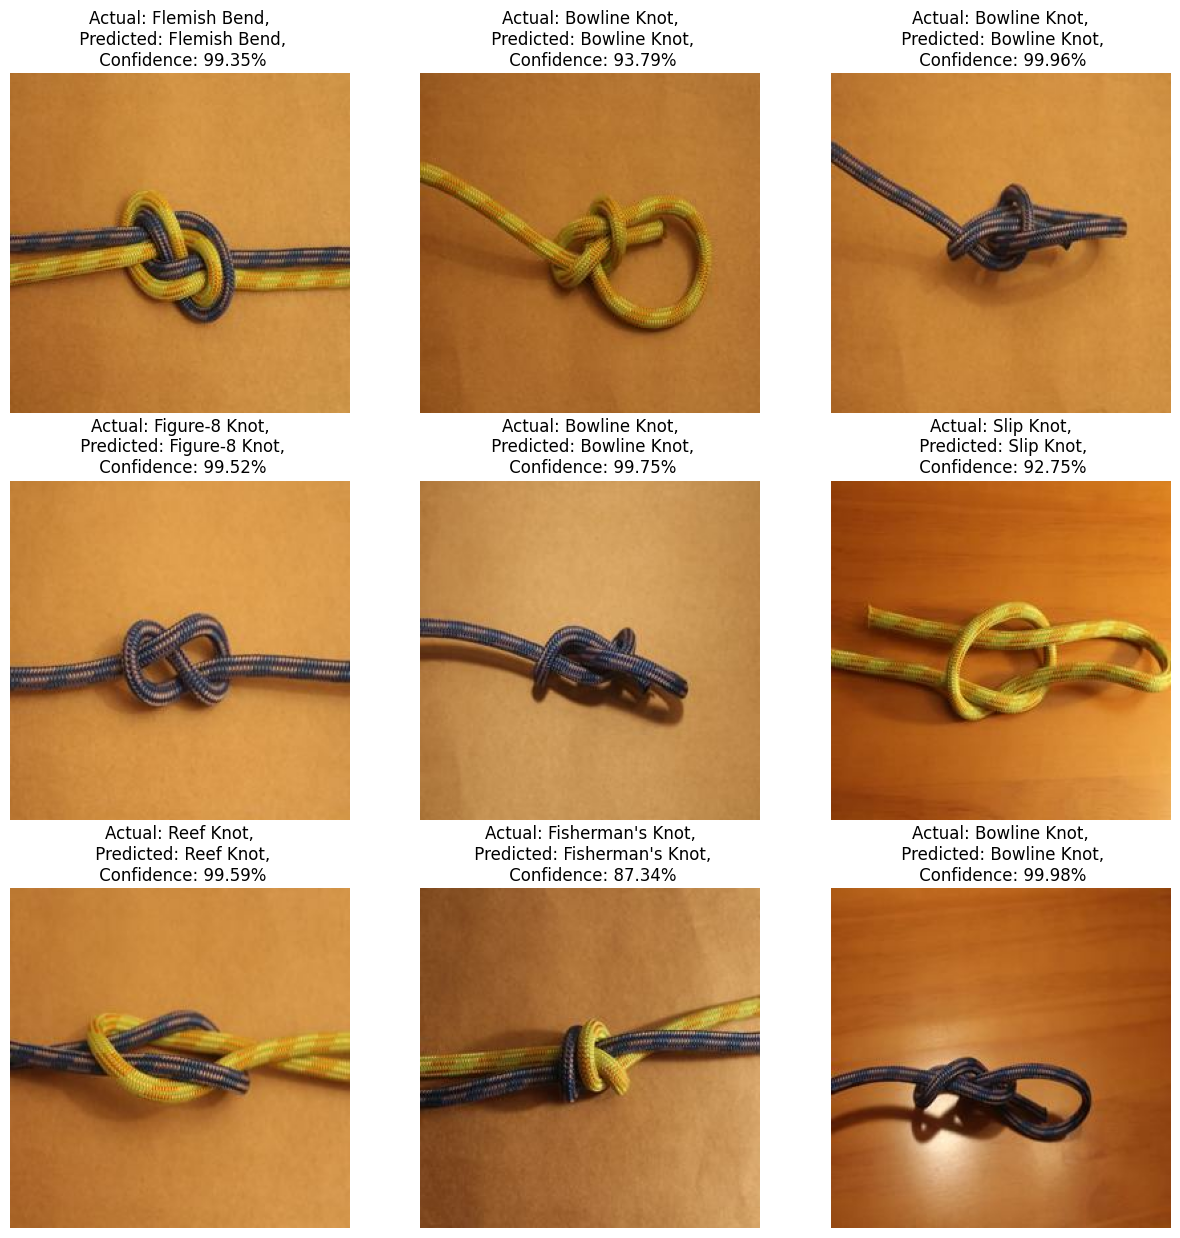

In [24]:
'''
Method calls predict method and displays visualizations of 9 images in dataset along with the actual class, predicted class, and confidence.
'''
plt.figure(figsize=(15,15)) #increase dimension to enlarge images
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

In [26]:
"""
Save model
Note: Create folder models at destination location before running
"""
model_version = 4
resnet_model.save(f"../models/{model_version}.keras")